In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time  # For potential additional waits

<div id="wrap"><header class="EntertainHeader_entertain_header__0sMAk"><div class="EntertainHeader_entertain_gnb__2ZFbT"><h1 class="EntertainHeader_logo_area__Vqrsh"><a class="EntertainHeader_link_naver__PUpG0" href="https://www.naver.com"><svg aria-hidden="true" class="icon_naver" fill="none" height="20" viewbox="0 0 20 20" width="20" xmlns="http://www.w3.org/2000/svg"><path clip-rule="evenodd" d="M20 20h-6.146L6.44 9.296V20H0V0h6.147l7.414 10.704V0h6.44v20z" fill="#3CD14B" fill-rule="evenodd"></path></svg><span class="blind">NAVER</span></a><a class="EntertainHeader_link_entertain__XUOiW" href="/home"><svg aria-hidden="true" class="EntertainHeader_icon_entertain__FJFKC" fill="none" height="20" width="35" xmlns="http://www.w3.org/2000/svg"><path d="M14.32.48h2.42V14.3h-2.42V.48zm-3.96 6.5H8.6c-.2 3.04-1.86 4.52-4.04 4.52-2.32 0-4.1-1.68-4.1-5.14v-.3c0-3.5 1.78-5.18 4.1-5.18 2 0 3.58 1.26 3.96 3.86h1.84V.68h2.34V13.7h-2.34V6.98zm-7.56-.9v.26c0 1.92.8 2.92 1.76 2.92.94 0 1.74-1 1.74-2.9
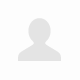
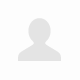

KeyboardInterrupt: 

In [2]:
url = "https://m.entertain.naver.com/ranking?rankingDate=20240101"

# Initialize the ChromeDriver (make sure it's in your PATH or specify the path)
driver = webdriver.Chrome()  # If in PATH
# Alternative (specifying path):
# driver = webdriver.Chrome(executable_path="/path/to/chromedriver.exe")  # Replace with your actual path

driver.get(url)  # Load the URL

# --- Explicit Waits (CRUCIAL!) ---
try:
    # Wait for a specific element to be present on the page.  This is the most reliable way.
    element_present = EC.presence_of_element_located((By.ID, 'wrap'))  # Wait for the 'wrap' div
    WebDriverWait(driver, 10).until(element_present)  # Wait up to 10 seconds

    # Alternative wait (less reliable):
    # time.sleep(5)  # Wait for 5 seconds (not recommended, use explicit waits if possible)

except:
    print("Timed out waiting for element")
    driver.quit()  # Close the browser
    exit()  # Exit the script

html = driver.page_source  # Get the HTML after JavaScript execution
soup = BeautifulSoup(html, "html.parser")

full_page = soup.find("div", attrs={"id": "wrap"})  # Now you should find the element
print(full_page)

driver.quit()  # Close the browser

# 여기 기준 위에는 됨

In [3]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import os
import csv
from datetime import date, timedelta

In [4]:
BASE_DIR = "C:\\Users\\WINDOWS11\\Desktop\\kpop_agenda\\Step1\\Articles"  # Adjust if needed

In [5]:
def fetch_html(url):
    time.sleep(1 + 2 * time.random())  # Sleep 1-3 seconds
    headers = {"User-Agent": "Mozilla/5.0"}  # Mimic a browser
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status() # Raise an exception for bad status codes (4xx or 5xx)
        return BeautifulSoup(response.content, "html.parser")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

In [6]:
def get_articles_for_day(ymd, max_articles=10):
    ranking_url = f"https://m.entertain.naver.com/ranking?rankingDate={ymd}"

    # Use Selenium for dynamic content loading
    driver = webdriver.Chrome()  # Make sure ChromeDriver is in your PATH
    driver.get(ranking_url)

    try:
        element_present = EC.presence_of_element_located((By.CSS_SELECTOR, 'li.NewsItem_news_item__fhEmd')) # Wait for articles to load
        WebDriverWait(driver, 10).until(element_present)
    except:
        print("Timed out waiting for element")
        driver.quit()
        return [] # Return empty list if scraping fails

    soup = BeautifulSoup(driver.page_source, "html.parser") # Get rendered HTML
    driver.quit()

    article_nodes = soup.select("li.NewsItem_news_item__fhEmd")

    articles = []
    for i, node in enumerate(article_nodes[:min(len(article_nodes), max_articles)]):
        rank_tag = node.select_one("div.NewsItem_rank_area__wqmaA span.blind")
        rank = int(rank_tag.text) if rank_tag else 0

        a_tag = node.select_one("a")
        link = a_tag["href"] if a_tag else ""

        title_tag = node.select_one("em.NewsItem_title__BXkJ6")
        title = title_tag.text if title_tag else ""

        views_tag = node.select_one("span.NewsItem_view__Tep-c")
        views_str = views_tag.text.replace("조회수", "").replace(",", "").strip() if views_tag else ""
        views = int(views_str) if views_str.isdigit() else 0

        company = link.split("/")[-2] if link else "unknown"

        file_path = os.path.join(BASE_DIR, f"{ymd}_article_{i+1}.txt")
        articles.append([0, rank, views, company, title, link, file_path])

    return articles


In [7]:
def main():
    start_date = date(2024, 1, 1)
    end_date = date(2024, 12, 31)

    all_articles = []
    article_id = 1

    current_date = start_date
    while current_date <= end_date:
        ymd = current_date.strftime("%Y%m%d")
        try:
            daily_articles = get_articles_for_day(ymd)
            for article in daily_articles:
                article[0] = article_id  # Set ID
                all_articles.append(article)
                article_id += 1
        except Exception as e:
            print(f"Error on date {ymd}: {e}")

        current_date += timedelta(days=1)

    # Write to TSV
    with open(os.path.join(BASE_DIR, "articles_metadata.tsv"), "w", newline="", encoding="utf-8") as tsvfile:
        writer = csv.writer(tsvfile, delimiter="\t")
        writer.writerow(["ID", "rank", "views", "company", "title", "link", "file_path"])  # Header row
        writer.writerows(all_articles)

    print("Done! Saved TSV to:", os.path.join(BASE_DIR, "articles_metadata.tsv"))


if __name__ == "__main__":
    main()

Done! Saved TSV to: C:\Users\WINDOWS11\Desktop\kpop_agenda\Step1\Articles\articles_metadata.tsv
